# CS-GY 9223-D: Deep Learning Homework 2
Due on Friday, 12th March 2019, 11:55 PM

This homework can be done in pairs.

Write down the UNIs (NetIDs) of your group (if applicable)

Member 1: Hupo Tang, ht1073

Member 2: Name, NetID

In [1]:
import os
import numpy as np
import glob
import tensorflow as tf
from keras.utils import multi_gpu_model
from keras.applications import Xception

from keras.models import Sequential, Model

from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from keras.layers import Input
from keras.layers import Dense, Dropout, BatchNormalization, AveragePooling2D, concatenate, ZeroPadding2D
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras import regularizers
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import load_model

import cv2
# import matplotlib.pylab as plt
# %matplotlib inline

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [3]:
data_path = '../'
TRAIN = '../images_training_rev1/'
VALID = '../images_validation_rev1'
TEST = '../images_test_rev1/'
LABELS = '../training_solutions_rev1.csv'

## Train and validation data split

In [33]:
'''
Do not run twice ever!!!
'''

# g = glob.glob(data_path+'images_training_rev1/*.jpg')
# shuf = np.random.permutation(g)
# for i in range(2016):
#     os.rename(shuf[i], data_path + 'images_validation_rev1/' + shuf[i].split("/")[-1])

'\nDo not run twice!!!\n'

## Data preprocessing

### Use numpy array

In [3]:
# import pd as 
# groundtruth_train=pd.read_csv('./training_solutions_rev1.csv') # train中每个图像的相关类别的概率分布, dataframe type

lst=os.listdir('../images_training_rev1/') # train中每个图像的filename，即图像id，构成的list
# lst.sort()
len(lst)
lst_v = os.listdir('../images_validation_rev1/')
len(lst_v)

59562

2016

In [4]:
X_train, y_train = np.load('../X_train.npy'), np.load('../y_train.npy')
X_val, y_val = np.load('../X_val.npy'), np.load('../y_val.npy')
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((59562, 69, 69, 3), (59562, 37))

((2016, 69, 69, 3), (2016, 37))

In [44]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=270,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [45]:
datagen.fit(X_train)

### Use generator

In [4]:
from random import shuffle
from scipy.misc import imresize
import csv

class data_loader:    
    """
    Creates a class for handling train/valid/test data paths,
    training labels and image IDs.
    Useful for switching between sample and full datasets.
    """
    def __init__(self, path):    
        self.path = path 
        self.train_path = TRAIN
        self.val_path = VALID
        self.test_path = TEST
        
        def get_paths(directory):
            return [f for f in os.listdir(directory)]
        
        self.training_images_paths = get_paths(self.train_path)
        self.validation_images_paths = get_paths(self.val_path)
        self.test_images_paths = get_paths(self.test_path)    
        
        def get_all_solutions():
        # Import solutions file and load into self.solutions
            all_solutions = {}
            # /'training_solutions_rev1.csv'
            with open(LABELS, 'r') as f:
                reader = csv.reader(f, delimiter=",")
                next(reader)
                for i, line in enumerate(reader):
                    all_solutions[line[0]] = [float(x) for x in line[1:]]
            return all_solutions
        
        self.all_solutions = get_all_solutions()

    def get_id(self,fname):
        return fname.replace(".jpg","").replace("data","")
        
    def find_label(self,val):
        return self.all_solutions[val]

In [5]:
def process_images(paths):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    This is images processing for VGG Model.
    """
    count = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    for c, path in enumerate(paths):
        img = cv2.imread(path).T
        img = img[:,106:106*3,106:106*3] #crop 424x424 -> 212x212
        img = imresize(img,size=(106,106,3),interp="cubic").T # downsample to half res
        arr[c] = img
    return arr

def BatchGenerator(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images([getter.train_path + '/' + fname for fname in [f]])
            X_train = np.reshape(X_train, (1,106,106,3))
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)

def validGenerator(getter):
    while 1:
        for f in getter.validation_images_paths:
            X_val = process_images([getter.val_path + '/' + fname for fname in [f]])
            X_val = np.reshape(X_val, (1,106,106,3))
            id_ = getter.get_id(f)
            y_val = np.array(getter.find_label(id_))
            y_val = np.reshape(y_val, (1,37))
            yield (X_val, y_val)

### Data augmentation

In [5]:
# Expanded the original data by five times by rotating and flipping。

def rotate90(img):
    return np.rot90(img)

def rotate180(img):
    tmp = np.rot90(img)
    return np.rot90(tmp)

def rotate270(img):
    tmp = np.rot90(img)
    tmp = np.rot90(tmp)
    return np.rot90(tmp)

def flip_h(img):
    return np.flip(img, axis=1)

def flip_v(img):
    return np.flip(img, axis=2)

In [9]:
from scipy.misc import imresize

aug = 1
while aug<6:
    auger={0:lambda x:x,1:rotate90,2:flip_h,3:rotate180,4:rotate270,5:flip_v}.get(aug,lambda x:x)
    train_aug = []
    for i in range(X_train.shape[0]):
        img = X_train[i,:]
        img = auger(img)
        img = imresize(img,size=(69,69,3),interp="cubic")
        train_aug.append(img)
    train = np.stack(train_aug)
    np.save('../X_train'+str(aug), train)
    aug += 1
    

In [11]:
X_train1 = np.load('../X_train1.npy')
X_train2 = np.load('../X_train2.npy')
X_train3 = np.load('../X_train3.npy')
X_train4 = np.load('../X_train4.npy')
X_train5 = np.load('../X_train5.npy')

In [12]:
tmp = np.append(X_train, X_train1, axis=0)
X_aug = np.append(tmp, X_train2, axis = 0)
X_aug.shape

(178686, 69, 69, 3)

In [16]:
tmp = np.append(y_train, y_train, axis=0)
y_aug = np.append(tmp, y_train, axis=0)
y_aug.shape

(178686, 37)

In [6]:
def process_withaug(paths,aug=0):
    count = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    for c, path in enumerate(paths):
        raw_img = cv2.imread(path).T
        auger={0:lambda x:x,1:rotate90,2:rotate180,3:rotate270,4:flip_h,5:flip_v}.get(aug,lambda x:x)
        img=auger(raw_img)
        img = img[:,106:106*3,106:106*3]
        img = imresize(img,size=(106,106,3),interp="cubic").T
        arr[c] = img
    return arr

def BatchGenerator_withaug(getter):
    while 1:
        for f in getter.training_images_paths:
            for aug in {0,1,2,3,4,5}:
                X_train = process_withaug([getter.train_path + '/' + fname for fname in [f]], aug)
                X_train = np.reshape(X_train, (1,106,106,3))
                id_ = getter.get_id(f)
                y_train = np.array(getter.find_label(id_))
                y_train = np.reshape(y_train,(1,37))
                yield (X_train, y_train)


In [16]:
def process_images2(paths,aug=0):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    """
    count = len(paths)
    arr = np.zeros(shape=(count,3,69,69))
    for c, path in enumerate(paths):
        raw_img = cv2.imread(path).T
        auger={0:lambda x:x,1:rotate90,2:flip_h,3:rotate270,4:rotate180,5:flip_v}.get(aug,lambda x:x)
        img=auger(raw_img)
        img = img[:,108:315,108:315] #crop 424x424 -> 207x207
        img = imresize(img,size=(69,69,3),interp="cubic").T # downsample
        
#         img1 = np.sqrt(img[:1,:,:]*255)
#         img2 = np.sqrt(img[1:2,:,:])
#         img2 = np.append(img1, img2, axis=0)
#         img3 = np.sqrt(img[2:3,:,:])
#         img = np.append(img2, img3.reshape((1,69,69)), axis=0)
        
        arr[c] = img
    return arr

def BatchGenerator2(getter):
    while 1:
        for f in getter.training_images_paths:
            for aug in {0}:
                X_train = process_images2([getter.train_path + '/' + fname for fname in [f]], aug)
                X_train = np.reshape(X_train,(1,69,69,3))
                id_ = getter.get_id(f)
                y_train = np.array(getter.find_label(id_))
                y_train = np.reshape(y_train,(1,37))
                assert(X_train.shape==(1,69,69,3))
                yield (X_train,y_train)

def validGenerator2(getter):
    while 1:
        for f in getter.validation_images_paths:
            X_val = process_images2([getter.val_path + '/' + fname for fname in [f]])
            X_val = np.reshape(X_val, (1,69,69,3))
            id_ = getter.get_id(f)
            y_val = np.array(getter.find_label(id_))
            y_val = np.reshape(y_val, (1,37))
            yield (X_val, y_val)


In [17]:
def BatchGenerator3(getter,batch_size=32):
    batch_x,batch_y=[],[]
    while 1:
        img_id=0
        while(img_id<len(getter.training_images_paths)):
            f=getter.training_images_paths[img_id]
            aug=0
            while(aug<3):
                X_train = process_images2([getter.train_path + '/' + fname for fname in [f]], aug)
                X_train = np.reshape(X_train,(69,69,3))
                id_ = getter.get_id(f)
                y_train = np.array(getter.find_label(id_))
                y_train = np.reshape(y_train,(37))
                batch_x.append(X_train)
                batch_y.append(y_train)
                if len(batch_x)>=batch_size:
                    yield np.stack(batch_x),np.stack(batch_y)
                    batch_x,batch_y=[],[]
                aug+=1
            img_id+=1

def validGenerator3(getter,batch_size=32):
    batch_x,batch_y=[],[]
    while(True):
        img_id=0
        while(img_id<len(getter.validation_images_paths)):
            aug=0
            f=getter.validation_images_paths[img_id]
            while(aug<1):
                X_val = process_images2([getter.val_path + '/' + fname for fname in [f]])
                X_val = np.reshape(X_val, (69,69,3))
                id_ = getter.get_id(f)
                y_val = np.array(getter.find_label(id_))
                y_val = np.reshape(y_val, (37))
                batch_x.append(X_val)
                batch_y.append(y_val)
                if len(batch_x)>=batch_size:
                    yield np.stack(batch_x),np.stack(batch_y)
                    batch_x,batch_y=[],[]
                aug+=1
                img_id+=1


In [19]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [10]:
fetcher = data_loader(data_path)

In [11]:
len(fetcher.validation_images_paths)

2016

## Build Model

### VGG

In [12]:
def ConvBlock(layers, model, filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Convolution2D(filters, 3, 3, activation='relu'))  # 3x3 filter size 
    model.add(MaxPooling2D((1,1), strides=(2,2)))

def FCBlock(model):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def VGG_16():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(106,106,3)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model

def VGG_16_2():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(69,69,3)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model

In [27]:
# Compile 
optimizer = RMSprop(lr=1e-6)
model = VGG_16()
model2 = VGG_16_2()
model.compile(loss='mean_squared_error', optimizer=optimizer)
model2.compile(loss='mean_squared_error', optimizer=RMSprop(lr=1e-6))

### My CNN design 

In [48]:
def MyCNN():
    model = Sequential()
    #NHWC(,69,69,3)
    model.add(Lambda(lambda x: x, input_shape=(69,69,3)))
#     print(model.output_shape)    

    model.add(Convolution2D(8, 4, 4, activation='relu'))
    model.add(Convolution2D(16, 3, 3, activation='relu'))
#     model.add(Convolution2D(32, 6, 6, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
#     model.add(Convolution2D(64, 5, 5, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(128, 3, 3, activation='relu', W_regularizer=regularizers.l2(0.001)))
    model.add(Convolution2D(128, 3, 3, activation='relu', W_regularizer=regularizers.l2(0.01)))
#     model.add(Convolution2D(256, 3, 3, activation='relu', W_regularizer=regularizers.l2(0.01)))
    
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(2048, activation='elu'))
#     model.add(Dense(4096, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(2048, activation='elu'))
#     model.add(Dense(4096, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(37, activation='sigmoid'))
    return model

In [49]:
myModel = MyCNN()
myModel = multi_gpu_model(myModel, gpus=2)

In [50]:
myModel.compile(loss='mean_squared_error', optimizer=Adam(lr=5e-5))

### ResNet

In [45]:
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu')(x)
#     print(x.shape)
    x = BatchNormalization(axis=3)(x)
    return x

def identity_Block(inpt, nb_filter, kernel_size, strides=(1, 1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=nb_filter, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def bottleneck_Block(inpt,nb_filters,strides=(1,1),with_conv_shortcut=False):
    k1,k2,k3=nb_filters
    x = Conv2d_BN(inpt, nb_filter=k1, kernel_size=1, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=k2, kernel_size=3, padding='same')
    x = Dropout(0.2)(x)
    x = Conv2d_BN(x, nb_filter=k3, kernel_size=1, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=k3, strides=strides, kernel_size=1)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def resnet_50(width,height,channel,classes):
    inpt = Input(shape=(width, height, channel))
    x = ZeroPadding2D((2, 2))(inpt)
    x = Conv2d_BN(x, nb_filter=64, kernel_size=(6, 6), strides=(1, 1), padding='valid')
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    #conv2_x
    x = bottleneck_Block(x, nb_filters=[64,64,256],strides=(1,1),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[64,64,256])

    #conv3_x
    x = bottleneck_Block(x, nb_filters=[128, 128, 512],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])

    #conv4_x
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])

    #conv5_x
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048], strides=(2, 2), with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048])

    x = AveragePooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(classes, activation='sigmoid')(x)

    model = Model(inputs=inpt, outputs=x)
    return model



In [ ]:

resModel = resnet_50(69,69,3,37)
resModel = multi_gpu_model(resModel, gpus=2)
# model.summary()
resModel.compile(loss='mean_squared_error', optimizer=Adam(lr=5e-5))

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='./tmp/resWeights.hdf5', verbose=1, save_best_only=True)

batch_size = 32
len(fetcher.training_images_paths),len(fetcher.validation_images_paths)
steps_to_take = len(fetcher.training_images_paths)//batch_size
val_steps_to_take = len(fetcher.validation_images_paths)//batch_size
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.
steps_to_take,val_steps_to_take
steps_to_take*batch_size,val_steps_to_take*batch_size
history = LossHistory()


(59562, 2016)

(1861, 63)

(59552, 2016)

In [28]:
def gcd(a,b):
    d,r=a//b,a%b
    if r==0:
        return b
    return gcd(b,r)
gcd(59562, 2016)


18

In [48]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

## Train Model

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='./tmp/MyWeights.hdf5', verbose=1, save_best_only=True)
history = LossHistory()

In [35]:
input_shape = (69,69,3)
batch_size = 32
steps_to_take = int(X_train.shape[0]/batch_size)
val_step = int(X_val.shape[0]/batch_size)

In [52]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=30, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/30
 - 88s - loss: 0.3050 - val_loss: 0.0427

Epoch 00001: val_loss improved from inf to 0.04271, saving model to ./tmp/MyWeights.hdf5
Epoch 2/30
 - 85s - loss: 0.0324 - val_loss: 0.0251

Epoch 00002: val_loss improved from 0.04271 to 0.02512, saving model to ./tmp/MyWeights.hdf5
Epoch 3/30
 - 86s - loss: 0.0227 - val_loss: 0.0203

Epoch 00003: val_loss improved from 0.02512 to 0.02031, saving model to ./tmp/MyWeights.hdf5
Epoch 4/30
 - 86s - loss: 0.0187 - val_loss: 0.0168

Epoch 00004: val_loss improved from 0.02031 to 0.01682, saving model to ./tmp/MyWeights.hdf5
Epoch 5/30
 - 87s - loss: 0.0166 - val_loss: 0.0157

Epoch 00005: val_loss improved from 0.01682 to 0.01571, saving model to ./tmp/MyWeights.hdf5
Epoch 6/30
 - 86s - loss: 0.0153 - val_loss: 0.0143

Epoch 00006: val_loss improved from 0.01571 to 0.01433, saving model to ./tmp/MyWeights.hdf5
Epoch 7/30
 - 86s - loss: 0.0144 - val_loss: 0.0138

Epoch 00007: val_loss improved from 0.01433 to 0.01384, saving model to ./t

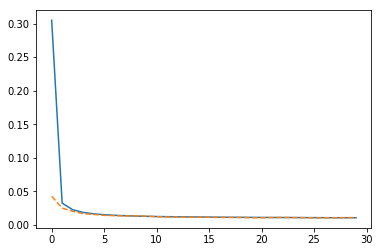

In [53]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [54]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 87s - loss: 0.0107 - val_loss: 0.0109

Epoch 00001: val_loss did not improve from 0.01048
Epoch 2/20
 - 86s - loss: 0.0106 - val_loss: 0.0105

Epoch 00002: val_loss improved from 0.01048 to 0.01047, saving model to ./tmp/MyWeights.hdf5
Epoch 3/20
 - 86s - loss: 0.0106 - val_loss: 0.0104

Epoch 00003: val_loss improved from 0.01047 to 0.01036, saving model to ./tmp/MyWeights.hdf5
Epoch 4/20
 - 86s - loss: 0.0106 - val_loss: 0.0103

Epoch 00004: val_loss improved from 0.01036 to 0.01032, saving model to ./tmp/MyWeights.hdf5
Epoch 5/20
 - 86s - loss: 0.0105 - val_loss: 0.0106

Epoch 00005: val_loss did not improve from 0.01032
Epoch 6/20
 - 86s - loss: 0.0105 - val_loss: 0.0107

Epoch 00006: val_loss did not improve from 0.01032
Epoch 7/20
 - 86s - loss: 0.0104 - val_loss: 0.0107

Epoch 00007: val_loss did not improve from 0.01032
Epoch 8/20
 - 86s - loss: 0.0104 - val_loss: 0.0108

Epoch 00008: val_loss did not improve from 0.01032
Epoch 9/20
 - 86s - loss: 0.0104 - val_los

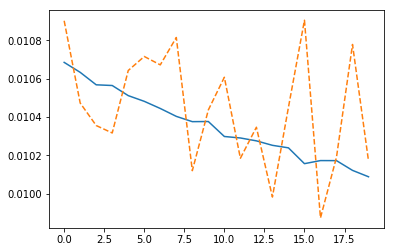

In [56]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [57]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 87s - loss: 0.0101 - val_loss: 0.0101

Epoch 00001: val_loss did not improve from 0.00987
Epoch 2/20
 - 86s - loss: 0.0100 - val_loss: 0.0101

Epoch 00002: val_loss did not improve from 0.00987
Epoch 3/20
 - 86s - loss: 0.0100 - val_loss: 0.0104

Epoch 00003: val_loss did not improve from 0.00987
Epoch 4/20
 - 86s - loss: 0.0100 - val_loss: 0.0099

Epoch 00004: val_loss did not improve from 0.00987
Epoch 5/20
 - 86s - loss: 0.0100 - val_loss: 0.0100

Epoch 00005: val_loss did not improve from 0.00987
Epoch 6/20
 - 86s - loss: 0.0100 - val_loss: 0.0101

Epoch 00006: val_loss did not improve from 0.00987
Epoch 7/20
 - 86s - loss: 0.0100 - val_loss: 0.0100

Epoch 00007: val_loss did not improve from 0.00987
Epoch 8/20
 - 86s - loss: 0.0099 - val_loss: 0.0099

Epoch 00008: val_loss did not improve from 0.00987
Epoch 9/20
 - 87s - loss: 0.0099 - val_loss: 0.0103

Epoch 00009: val_loss did not improve from 0.00987
Epoch 10/20
 - 86s - loss: 0.0099 - val_loss: 0.0100

Epoch 0001

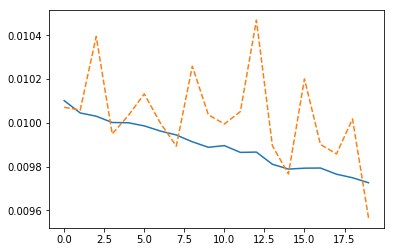

In [58]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [59]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 87s - loss: 0.0097 - val_loss: 0.0099

Epoch 00001: val_loss did not improve from 0.00956
Epoch 2/20
 - 86s - loss: 0.0097 - val_loss: 0.0097

Epoch 00002: val_loss did not improve from 0.00956
Epoch 3/20
 - 86s - loss: 0.0097 - val_loss: 0.0101

Epoch 00003: val_loss did not improve from 0.00956
Epoch 4/20
 - 86s - loss: 0.0097 - val_loss: 0.0097

Epoch 00004: val_loss did not improve from 0.00956
Epoch 5/20
 - 86s - loss: 0.0097 - val_loss: 0.0102

Epoch 00005: val_loss did not improve from 0.00956
Epoch 6/20
 - 86s - loss: 0.0096 - val_loss: 0.0100

Epoch 00006: val_loss did not improve from 0.00956
Epoch 7/20
 - 86s - loss: 0.0096 - val_loss: 0.0100

Epoch 00007: val_loss did not improve from 0.00956
Epoch 8/20
 - 86s - loss: 0.0096 - val_loss: 0.0097

Epoch 00008: val_loss did not improve from 0.00956
Epoch 9/20
 - 87s - loss: 0.0097 - val_loss: 0.0099

Epoch 00009: val_loss did not improve from 0.00956
Epoch 10/20
 - 86s - loss: 0.0096 - val_loss: 0.0099

Epoch 0001

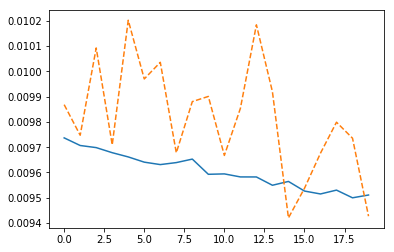

In [60]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [61]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 87s - loss: 0.0095 - val_loss: 0.0096

Epoch 00001: val_loss did not improve from 0.00942
Epoch 2/20
 - 86s - loss: 0.0095 - val_loss: 0.0098

Epoch 00002: val_loss did not improve from 0.00942
Epoch 3/20
 - 86s - loss: 0.0095 - val_loss: 0.0097

Epoch 00003: val_loss did not improve from 0.00942
Epoch 4/20
 - 86s - loss: 0.0094 - val_loss: 0.0099

Epoch 00004: val_loss did not improve from 0.00942
Epoch 5/20
 - 86s - loss: 0.0095 - val_loss: 0.0095

Epoch 00005: val_loss did not improve from 0.00942
Epoch 6/20
 - 86s - loss: 0.0094 - val_loss: 0.0094

Epoch 00006: val_loss improved from 0.00942 to 0.00936, saving model to ./tmp/MyWeights.hdf5
Epoch 7/20
 - 86s - loss: 0.0094 - val_loss: 0.0094

Epoch 00007: val_loss did not improve from 0.00936
Epoch 8/20
 - 86s - loss: 0.0094 - val_loss: 0.0094

Epoch 00008: val_loss did not improve from 0.00936
Epoch 9/20
 - 86s - loss: 0.0094 - val_loss: 0.0096

Epoch 00009: val_loss did not improve from 0.00936
Epoch 10/20
 - 86s - l

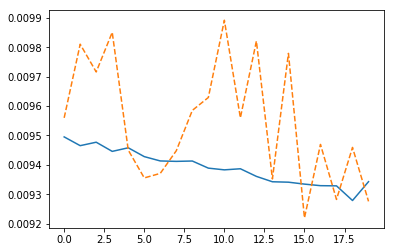

In [62]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [64]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 86s - loss: 0.0092 - val_loss: 0.0090

Epoch 00001: val_loss improved from 0.00916 to 0.00901, saving model to ./tmp/MyWeights.hdf5
Epoch 2/20
 - 85s - loss: 0.0092 - val_loss: 0.0094

Epoch 00002: val_loss did not improve from 0.00901
Epoch 3/20
 - 85s - loss: 0.0092 - val_loss: 0.0094

Epoch 00003: val_loss did not improve from 0.00901
Epoch 4/20
 - 85s - loss: 0.0091 - val_loss: 0.0094

Epoch 00004: val_loss did not improve from 0.00901
Epoch 5/20
 - 85s - loss: 0.0092 - val_loss: 0.0092

Epoch 00005: val_loss did not improve from 0.00901
Epoch 6/20
 - 85s - loss: 0.0092 - val_loss: 0.0094

Epoch 00006: val_loss did not improve from 0.00901
Epoch 7/20
 - 85s - loss: 0.0091 - val_loss: 0.0095

Epoch 00007: val_loss did not improve from 0.00901
Epoch 8/20
 - 85s - loss: 0.0091 - val_loss: 0.0091

Epoch 00008: val_loss did not improve from 0.00901
Epoch 9/20
 - 85s - loss: 0.0092 - val_loss: 0.0092

Epoch 00009: val_loss did not improve from 0.00901
Epoch 10/20
 - 85s - l

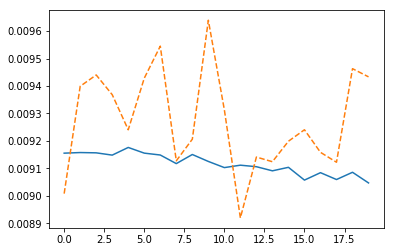

In [65]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [66]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 86s - loss: 0.0091 - val_loss: 0.0093

Epoch 00001: val_loss did not improve from 0.00892
Epoch 2/20
 - 85s - loss: 0.0090 - val_loss: 0.0092

Epoch 00002: val_loss did not improve from 0.00892
Epoch 3/20
 - 85s - loss: 0.0091 - val_loss: 0.0091

Epoch 00003: val_loss did not improve from 0.00892
Epoch 4/20
 - 85s - loss: 0.0090 - val_loss: 0.0090

Epoch 00004: val_loss did not improve from 0.00892
Epoch 5/20
 - 85s - loss: 0.0090 - val_loss: 0.0091

Epoch 00005: val_loss did not improve from 0.00892
Epoch 6/20
 - 85s - loss: 0.0090 - val_loss: 0.0094

Epoch 00006: val_loss did not improve from 0.00892
Epoch 7/20
 - 85s - loss: 0.0090 - val_loss: 0.0092

Epoch 00007: val_loss did not improve from 0.00892
Epoch 8/20
 - 85s - loss: 0.0090 - val_loss: 0.0090

Epoch 00008: val_loss did not improve from 0.00892
Epoch 9/20
 - 85s - loss: 0.0090 - val_loss: 0.0090

Epoch 00009: val_loss did not improve from 0.00892
Epoch 10/20
 - 85s - loss: 0.0090 - val_loss: 0.0091

Epoch 0001

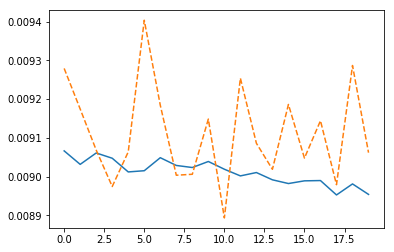

In [67]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [68]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 86s - loss: 0.0090 - val_loss: 0.0093

Epoch 00001: val_loss did not improve from 0.00889
Epoch 2/20
 - 85s - loss: 0.0090 - val_loss: 0.0091

Epoch 00002: val_loss did not improve from 0.00889
Epoch 3/20
 - 85s - loss: 0.0089 - val_loss: 0.0091

Epoch 00003: val_loss did not improve from 0.00889
Epoch 4/20
 - 85s - loss: 0.0090 - val_loss: 0.0089

Epoch 00004: val_loss did not improve from 0.00889
Epoch 5/20
 - 85s - loss: 0.0089 - val_loss: 0.0094

Epoch 00005: val_loss did not improve from 0.00889
Epoch 6/20
 - 85s - loss: 0.0089 - val_loss: 0.0093

Epoch 00006: val_loss did not improve from 0.00889
Epoch 7/20
 - 85s - loss: 0.0089 - val_loss: 0.0093

Epoch 00007: val_loss did not improve from 0.00889
Epoch 8/20
 - 85s - loss: 0.0089 - val_loss: 0.0090

Epoch 00008: val_loss did not improve from 0.00889
Epoch 9/20
 - 85s - loss: 0.0089 - val_loss: 0.0090

Epoch 00009: val_loss did not improve from 0.00889
Epoch 10/20
 - 85s - loss: 0.0089 - val_loss: 0.0089

Epoch 0001

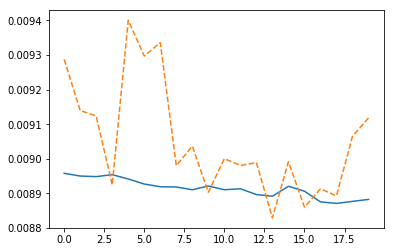

In [69]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [70]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 86s - loss: 0.0089 - val_loss: 0.0091

Epoch 00001: val_loss did not improve from 0.00883
Epoch 2/20
 - 85s - loss: 0.0088 - val_loss: 0.0088

Epoch 00002: val_loss did not improve from 0.00883
Epoch 3/20
 - 85s - loss: 0.0089 - val_loss: 0.0090

Epoch 00003: val_loss did not improve from 0.00883
Epoch 4/20
 - 85s - loss: 0.0089 - val_loss: 0.0089

Epoch 00004: val_loss did not improve from 0.00883
Epoch 5/20
 - 85s - loss: 0.0089 - val_loss: 0.0090

Epoch 00005: val_loss did not improve from 0.00883
Epoch 6/20
 - 85s - loss: 0.0088 - val_loss: 0.0091

Epoch 00006: val_loss did not improve from 0.00883
Epoch 7/20
 - 85s - loss: 0.0088 - val_loss: 0.0087

Epoch 00007: val_loss improved from 0.00883 to 0.00871, saving model to ./tmp/MyWeights.hdf5
Epoch 8/20
 - 85s - loss: 0.0088 - val_loss: 0.0089

Epoch 00008: val_loss did not improve from 0.00871
Epoch 9/20
 - 85s - loss: 0.0088 - val_loss: 0.0088

Epoch 00009: val_loss did not improve from 0.00871
Epoch 10/20
 - 85s - l

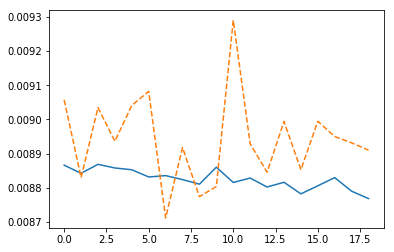

In [71]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [72]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 86s - loss: 0.0088 - val_loss: 0.0088

Epoch 00001: val_loss did not improve from 0.00871
Epoch 2/20
 - 85s - loss: 0.0088 - val_loss: 0.0087

Epoch 00002: val_loss did not improve from 0.00871
Epoch 3/20
 - 85s - loss: 0.0088 - val_loss: 0.0093

Epoch 00003: val_loss did not improve from 0.00871
Epoch 4/20
 - 85s - loss: 0.0088 - val_loss: 0.0087

Epoch 00004: val_loss improved from 0.00871 to 0.00871, saving model to ./tmp/MyWeights.hdf5
Epoch 5/20
 - 85s - loss: 0.0088 - val_loss: 0.0088

Epoch 00005: val_loss did not improve from 0.00871
Epoch 6/20
 - 85s - loss: 0.0088 - val_loss: 0.0091

Epoch 00006: val_loss did not improve from 0.00871
Epoch 7/20
 - 85s - loss: 0.0088 - val_loss: 0.0087

Epoch 00007: val_loss improved from 0.00871 to 0.00871, saving model to ./tmp/MyWeights.hdf5
Epoch 8/20
 - 85s - loss: 0.0088 - val_loss: 0.0095

Epoch 00008: val_loss did not improve from 0.00871
Epoch 9/20
 - 85s - loss: 0.0088 - val_loss: 0.0087

Epoch 00009: val_loss improved 

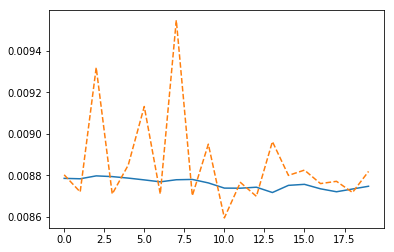

In [73]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [78]:
myHist = myModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=20, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/20
 - 86s - loss: 0.0086 - val_loss: 0.0092

Epoch 00001: val_loss did not improve from 0.00854
Epoch 2/20
 - 85s - loss: 0.0086 - val_loss: 0.0087

Epoch 00002: val_loss did not improve from 0.00854
Epoch 3/20
 - 85s - loss: 0.0086 - val_loss: 0.0090

Epoch 00003: val_loss did not improve from 0.00854
Epoch 4/20
 - 86s - loss: 0.0086 - val_loss: 0.0087

Epoch 00004: val_loss did not improve from 0.00854
Epoch 5/20
 - 85s - loss: 0.0086 - val_loss: 0.0086

Epoch 00005: val_loss did not improve from 0.00854
Epoch 6/20
 - 85s - loss: 0.0086 - val_loss: 0.0086

Epoch 00006: val_loss did not improve from 0.00854
Epoch 7/20
 - 86s - loss: 0.0086 - val_loss: 0.0086

Epoch 00007: val_loss did not improve from 0.00854
Epoch 8/20
 - 85s - loss: 0.0086 - val_loss: 0.0087

Epoch 00008: val_loss did not improve from 0.00854
Epoch 9/20
 - 85s - loss: 0.0086 - val_loss: 0.0087

Epoch 00009: val_loss did not improve from 0.00854
Epoch 10/20
 - 85s - loss: 0.0086 - val_loss: 0.0085

Epoch 0001

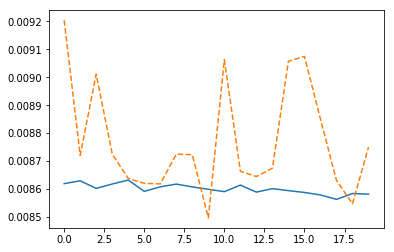

In [79]:
plt.plot(myHist.epoch,myHist.history['loss'],label='Test')
plt.plot(myHist.epoch,myHist.history['val_loss'],label='Validation',linestyle='--')

In [39]:
MyHist = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=30, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/30
 - 86s - loss: 0.0112 - val_loss: 0.0101

Epoch 00001: val_loss improved from inf to 0.01008, saving model to ./tmp/MyWeights.hdf5
Epoch 2/30
 - 86s - loss: 0.0107 - val_loss: 0.0102

Epoch 00002: val_loss did not improve from 0.01008
Epoch 3/30
 - 85s - loss: 0.0104 - val_loss: 0.0099

Epoch 00003: val_loss improved from 0.01008 to 0.00985, saving model to ./tmp/MyWeights.hdf5
Epoch 4/30
 - 85s - loss: 0.0103 - val_loss: 0.0098

Epoch 00004: val_loss improved from 0.00985 to 0.00979, saving model to ./tmp/MyWeights.hdf5
Epoch 5/30
 - 86s - loss: 0.0102 - val_loss: 0.0098

Epoch 00005: val_loss improved from 0.00979 to 0.00978, saving model to ./tmp/MyWeights.hdf5
Epoch 6/30
 - 86s - loss: 0.0101 - val_loss: 0.0099

Epoch 00006: val_loss did not improve from 0.00978
Epoch 7/30
 - 85s - loss: 0.0101 - val_loss: 0.0098

Epoch 00007: val_loss did not improve from 0.00978
Epoch 8/30
 - 86s - loss: 0.0100 - val_loss: 0.0097

Epoch 00008: val_loss improved from 0.00978 to 0.00975,

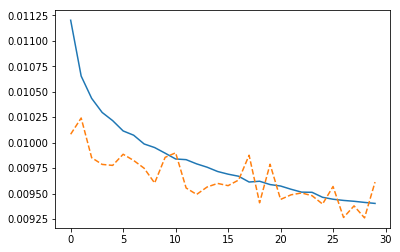

In [40]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(MyHist.epoch,MyHist.history['loss'],label='Test')
plt.plot(MyHist.epoch,MyHist.history['val_loss'],label='Validation',linestyle='--')

In [41]:
MyHist = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=30, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/30
 - 87s - loss: 0.0094 - val_loss: 0.0094

Epoch 00001: val_loss did not improve from 0.00926
Epoch 2/30
 - 86s - loss: 0.0094 - val_loss: 0.0094

Epoch 00002: val_loss did not improve from 0.00926
Epoch 3/30
 - 87s - loss: 0.0093 - val_loss: 0.0093

Epoch 00003: val_loss did not improve from 0.00926
Epoch 4/30
 - 86s - loss: 0.0093 - val_loss: 0.0092

Epoch 00004: val_loss improved from 0.00926 to 0.00925, saving model to ./tmp/MyWeights.hdf5
Epoch 5/30
 - 85s - loss: 0.0093 - val_loss: 0.0094

Epoch 00005: val_loss did not improve from 0.00925
Epoch 6/30
 - 85s - loss: 0.0093 - val_loss: 0.0094

Epoch 00006: val_loss did not improve from 0.00925
Epoch 7/30
 - 86s - loss: 0.0093 - val_loss: 0.0092

Epoch 00007: val_loss improved from 0.00925 to 0.00921, saving model to ./tmp/MyWeights.hdf5
Epoch 8/30
 - 86s - loss: 0.0093 - val_loss: 0.0094

Epoch 00008: val_loss did not improve from 0.00921
Epoch 9/30
 - 86s - loss: 0.0093 - val_loss: 0.0093

Epoch 00009: val_loss did not i

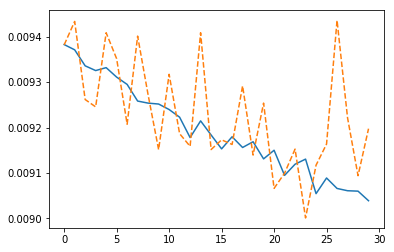

In [42]:
plt.plot(MyHist.epoch,MyHist.history['loss'],label='Test')
plt.plot(MyHist.epoch,MyHist.history['val_loss'],label='Validation',linestyle='--')

In [46]:
MyHist = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=15, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/15
 - 86s - loss: 0.0089 - val_loss: 0.0091

Epoch 00001: val_loss did not improve from 0.00897
Epoch 2/15
 - 86s - loss: 0.0089 - val_loss: 0.0089

Epoch 00002: val_loss improved from 0.00897 to 0.00893, saving model to ./tmp/MyWeights.hdf5
Epoch 3/15
 - 86s - loss: 0.0089 - val_loss: 0.0090

Epoch 00003: val_loss did not improve from 0.00893
Epoch 4/15
 - 86s - loss: 0.0089 - val_loss: 0.0090

Epoch 00004: val_loss did not improve from 0.00893
Epoch 5/15
 - 86s - loss: 0.0089 - val_loss: 0.0090

Epoch 00005: val_loss did not improve from 0.00893
Epoch 6/15
 - 86s - loss: 0.0089 - val_loss: 0.0089

Epoch 00006: val_loss improved from 0.00893 to 0.00889, saving model to ./tmp/MyWeights.hdf5
Epoch 7/15
 - 86s - loss: 0.0089 - val_loss: 0.0090

Epoch 00007: val_loss did not improve from 0.00889
Epoch 8/15
 - 86s - loss: 0.0089 - val_loss: 0.0091

Epoch 00008: val_loss did not improve from 0.00889
Epoch 9/15
 - 86s - loss: 0.0089 - val_loss: 0.0091

Epoch 00009: val_loss did not i

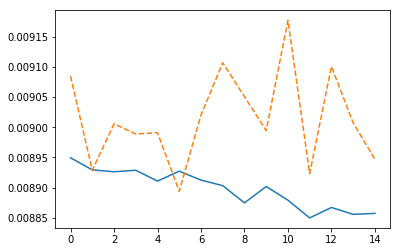

In [47]:
plt.plot(MyHist.epoch,MyHist.history['loss'],label='Test')
plt.plot(MyHist.epoch,MyHist.history['val_loss'],label='Validation',linestyle='--')

In [18]:
MyModel = MyCNN()
MyModel = multi_gpu_model(MyModel, gpus=2)
MyModel.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-5))

In [ ]:
MyHist1 = MyModel.fit(x=X_aug, y=y_aug, batch_size=batch_size,
#                         steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
#                         validation_steps=val_step,
                        epochs=30, verbose=2, 
                        callbacks=[history,checkpointer,early_stopping])

Train on 178686 samples, validate on 2016 samples
Epoch 1/30
 - 200s - loss: 0.4144 - val_loss: 0.0744

Epoch 00001: val_loss improved from inf to 0.07435, saving model to ./tmp/MyWeights.hdf5
Epoch 2/30
 - 198s - loss: 0.0458 - val_loss: 0.0310

Epoch 00002: val_loss improved from 0.07435 to 0.03103, saving model to ./tmp/MyWeights.hdf5
Epoch 3/30
 - 197s - loss: 0.0255 - val_loss: 0.0213

Epoch 00003: val_loss improved from 0.03103 to 0.02133, saving model to ./tmp/MyWeights.hdf5
Epoch 4/30
 - 198s - loss: 0.0188 - val_loss: 0.0167

Epoch 00004: val_loss improved from 0.02133 to 0.01667, saving model to ./tmp/MyWeights.hdf5
Epoch 5/30
 - 198s - loss: 0.0155 - val_loss: 0.0143

Epoch 00005: val_loss improved from 0.01667 to 0.01430, saving model to ./tmp/MyWeights.hdf5
Epoch 6/30
 - 198s - loss: 0.0136 - val_loss: 0.0132

Epoch 00006: val_loss improved from 0.01430 to 0.01324, saving model to ./tmp/MyWeights.hdf5
Epoch 7/30
 - 198s - loss: 0.0124 - val_loss: 0.0121

Epoch 00007: val_l

In [29]:
MyHist1 = MyModel.fit(x=X_aug, y=y_aug, batch_size=batch_size,
#                         steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
#                         validation_steps=val_step,
                        epochs=30, verbose=2, 
                        callbacks=[history,checkpointer,early_stopping])

Train on 178686 samples, validate on 2016 samples
Epoch 1/30
 - 198s - loss: 0.0103 - val_loss: 0.0104

Epoch 00001: val_loss improved from 0.01057 to 0.01044, saving model to ./tmp/MyWeights.hdf5
Epoch 2/30
 - 197s - loss: 0.0101 - val_loss: 0.0102

Epoch 00002: val_loss improved from 0.01044 to 0.01025, saving model to ./tmp/MyWeights.hdf5
Epoch 3/30
 - 198s - loss: 0.0099 - val_loss: 0.0104

Epoch 00003: val_loss did not improve from 0.01025
Epoch 4/30
 - 198s - loss: 0.0098 - val_loss: 0.0105

Epoch 00004: val_loss did not improve from 0.01025
Epoch 5/30
 - 197s - loss: 0.0097 - val_loss: 0.0099

Epoch 00005: val_loss improved from 0.01025 to 0.00991, saving model to ./tmp/MyWeights.hdf5
Epoch 6/30
 - 198s - loss: 0.0096 - val_loss: 0.0100

Epoch 00006: val_loss did not improve from 0.00991
Epoch 7/30
 - 198s - loss: 0.0095 - val_loss: 0.0101

Epoch 00007: val_loss did not improve from 0.00991
Epoch 8/30
 - 198s - loss: 0.0094 - val_loss: 0.0100

Epoch 00008: val_loss did not impro

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(MyHist1.epoch,MyHist1.history['loss'],label='Test')
plt.plot(MyHist1.epoch,MyHist1.history['val_loss'],label='Validation',linestyle='--')

In [26]:
myModel = load_model('./tmp/myWeights.hdf5')

In [ ]:
myhist1 = myModel.fit_generator(BatchGenerator3(fetcher),
                    samples_per_epoch=steps_to_take*3,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator3(fetcher),
                    validation_steps=val_steps_to_take
                   )

In [26]:
# resModel = load_model('./tmp/resWeights.hdf5')

In [ ]:
# ResNet

reshist = resModel.fit_generator(BatchGenerator3(fetcher,batch_size),
                    steps_per_epoch=steps_to_take,
                    nb_epoch=50,
                    verbose=1,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator3(fetcher,batch_size),
                    validation_steps=val_steps_to_take
                    )

Epoch 1/50
1861/1861 [==============================] - 446s 240ms/step - loss: 0.0281 - val_loss: 0.0260

Epoch 00001: val_loss improved from inf to 0.02603, saving model to ./tmp/resWeights.hdf5
Epoch 2/50
 361/1861 [====>.........................] - ETA: 6:36 - loss: 0.0272

In [ ]:


reshist = resModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                    )

In [ ]:
# VGG16 with no augmentation

hist = model.fit_generator(BatchGenerator(fetcher),
                    samples_per_epoch=steps_to_take, 
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                   )
# 0.021

In [ ]:
# VGG16 with augmentation

hist_aug = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*3, 
                    nb_epoch=25,
                    verbose=2,
                    callbacks=[hist,checkpointer,early_stopping],
                   )
# 0.017

In [ ]:
#Aug with larger epochs

hist_aug2 = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*3, 
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[hist,checkpointer,early_stopping],
                   )
# 0.015

In [141]:
# VGG with data augmentation

hist_vaug = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[hist_v2,checkpointer,early_stopping],
                    validation_data=validGenerator(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 54s - loss: 0.0161 - val_loss: 0.0176

Epoch 00001: val_loss did not improve from 0.01435
Epoch 2/50
 - 54s - loss: 0.0159 - val_loss: 0.0140

Epoch 00002: val_loss improved from 0.01435 to 0.01405, saving model to ./tmp/weights.hdf5
Epoch 3/50
 - 54s - loss: 0.0154 - val_loss: 0.0155

Epoch 00003: val_loss did not improve from 0.01405
Epoch 4/50
 - 54s - loss: 0.0154 - val_loss: 0.0140

Epoch 00004: val_loss improved from 0.01405 to 0.01400, saving model to ./tmp/weights.hdf5
Epoch 5/50
 - 54s - loss: 0.0155 - val_loss: 0.0156

Epoch 00005: val_loss did not improve from 0.01400
Epoch 6/50
 - 54s - loss: 0.0158 - val_loss: 0.0159

Epoch 00006: val_loss did not improve from 0.01400
Epoch 7/50
 - 54s - loss: 0.0160 - val_loss: 0.0145

Epoch 00007: val_loss did not improve from 0.01400
Epoch 8/50
 - 54s - loss: 0.0157 - val_loss: 0.0149

Epoch 00008: val_loss did not improve from 0.01400
Epoch 9/50
 - 54s - loss: 0.0155 - val_loss: 0.0164

Epoch 00009: val_loss did not impro

In [25]:
# VGG_2

hist2 = model2.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
 - 268s - loss: 0.0171 - val_loss: 0.0353

Epoch 00001: val_loss improved from inf to 0.03526, saving model to ./tmp/weights.hdf5
Epoch 2/30
 - 269s - loss: 0.0159 - val_loss: 0.0411

Epoch 00002: val_loss did not improve from 0.03526
Epoch 3/30
 - 268s - loss: 0.0150 - val_loss: 0.0181

Epoch 00003: val_loss improved from 0.03526 to 0.01809, saving model to ./tmp/weights.hdf5
Epoch 4/30
 - 268s - loss: 0.0144 - val_loss: 0.0215

Epoch 00004: val_loss did not improve from 0.01809
Epoch 5/30
 - 268s - loss: 0.0140 - val_loss: 0.0343

Epoch 00005: val_loss did not improve from 0.01809
Epoch 6/30
 - 269s - loss: 0.0136 - val_loss: 0.0204

Epoch 00006: val_loss did not improve from 0.01809
Epoch 7/30
 - 268s - loss: 0.0135 - val_loss: 0.0172

Epoch 00007: val_loss improved from 0.01809 to 0.01721, saving model to ./tmp/weights.hdf5
Epoch 8/30
 - 269s - loss: 0.0134 - val_loss: 0.0323

Epoch 00008: val_loss did not improve from 0.01721
Epoch 9/30
 - 268s - loss: 0.0127 - val_loss

In [28]:
# VGG_2 train more

hist = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
 - 324s - loss: 0.0340 - val_loss: 0.0286

Epoch 00001: val_loss did not improve from 0.01721
Epoch 2/30
 - 322s - loss: 0.0235 - val_loss: 0.0307

Epoch 00002: val_loss did not improve from 0.01721
Epoch 3/30
 - 322s - loss: 0.0201 - val_loss: 0.0235

Epoch 00003: val_loss did not improve from 0.01721
Epoch 4/30
 - 321s - loss: 0.0179 - val_loss: 0.0232

Epoch 00004: val_loss did not improve from 0.01721
Epoch 5/30
 - 322s - loss: 0.0172 - val_loss: 0.0367

Epoch 00005: val_loss did not improve from 0.01721
Epoch 6/30
 - 322s - loss: 0.0164 - val_loss: 0.0208

Epoch 00006: val_loss did not improve from 0.01721
Epoch 7/30
 - 322s - loss: 0.0160 - val_loss: 0.0192

Epoch 00007: val_loss did not improve from 0.01721
Epoch 8/30
 - 322s - loss: 0.0157 - val_loss: 0.0351

Epoch 00008: val_loss did not improve from 0.01721
Epoch 9/30
 - 322s - loss: 0.0150 - val_loss: 0.0244

Epoch 00009: val_loss did not improve from 0.01721
Epoch 10/30
 - 321s - loss: 0.0148 - val_loss: 0.0245



In [29]:
# VGG_2 train more

hist2 = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=70,
                    verbose=2,
                    callbacks=[hist,checkpointer,early_stopping],
                    validation_data=validGenerator(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/70
 - 321s - loss: 0.0117 - val_loss: 0.0419

Epoch 00001: val_loss did not improve from 0.01662
Epoch 2/70
 - 321s - loss: 0.0116 - val_loss: 0.0348

Epoch 00002: val_loss did not improve from 0.01662
Epoch 3/70
 - 321s - loss: 0.0110 - val_loss: 0.0196

Epoch 00003: val_loss did not improve from 0.01662
Epoch 4/70
 - 322s - loss: 0.0112 - val_loss: 0.0279

Epoch 00004: val_loss did not improve from 0.01662
Epoch 5/70
 - 322s - loss: 0.0113 - val_loss: 0.0271

Epoch 00005: val_loss did not improve from 0.01662
Epoch 6/70
 - 322s - loss: 0.0113 - val_loss: 0.0161

Epoch 00006: val_loss improved from 0.01662 to 0.01611, saving model to ./tmp/weights.hdf5
Epoch 7/70
 - 321s - loss: 0.0115 - val_loss: 0.0206

Epoch 00007: val_loss did not improve from 0.01611
Epoch 8/70
 - 322s - loss: 0.0113 - val_loss: 0.0222

Epoch 00008: val_loss did not improve from 0.01611
Epoch 9/70
 - 322s - loss: 0.0112 - val_loss: 0.0277

Epoch 00009: val_loss did not improve from 0.01611
Epoch 10/70
 - 

In [19]:
# my CNN

myhist = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 159s - loss: 0.0321 - val_loss: 0.0221

Epoch 00001: val_loss improved from 0.04341 to 0.02207, saving model to ./tmp/myWeights.hdf5
Epoch 2/50
 - 156s - loss: 0.0197 - val_loss: 0.0175

Epoch 00002: val_loss improved from 0.02207 to 0.01753, saving model to ./tmp/myWeights.hdf5
Epoch 3/50
 - 156s - loss: 0.0173 - val_loss: 0.0167

Epoch 00003: val_loss improved from 0.01753 to 0.01667, saving model to ./tmp/myWeights.hdf5
Epoch 4/50
 - 155s - loss: 0.0164 - val_loss: 0.0180

Epoch 00004: val_loss did not improve from 0.01667
Epoch 5/50
 - 155s - loss: 0.0158 - val_loss: 0.0156

Epoch 00005: val_loss improved from 0.01667 to 0.01563, saving model to ./tmp/myWeights.hdf5
Epoch 6/50
 - 155s - loss: 0.0155 - val_loss: 0.0144

Epoch 00006: val_loss improved from 0.01563 to 0.01440, saving model to ./tmp/myWeights.hdf5
Epoch 7/50
 - 155s - loss: 0.0156 - val_loss: 0.0133

Epoch 00007: val_loss improved from 0.01440 to 0.01331, saving model to ./tmp/myWeights.hdf5
Epoch 8/50
 -

In [24]:
# 增大R通道的数值，但效果不明显

myhist2 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 156s - loss: 0.0262 - val_loss: 0.0245

Epoch 00001: val_loss did not improve from 0.00923
Epoch 2/50
 - 156s - loss: 0.0214 - val_loss: 0.0209

Epoch 00002: val_loss did not improve from 0.00923
Epoch 3/50
 - 156s - loss: 0.0198 - val_loss: 0.0208

Epoch 00003: val_loss did not improve from 0.00923
Epoch 4/50
 - 156s - loss: 0.0190 - val_loss: 0.0180

Epoch 00004: val_loss did not improve from 0.00923
Epoch 5/50
 - 156s - loss: 0.0182 - val_loss: 0.0166

Epoch 00005: val_loss did not improve from 0.00923
Epoch 6/50
 - 156s - loss: 0.0180 - val_loss: 0.0153

Epoch 00006: val_loss did not improve from 0.00923
Epoch 7/50
 - 156s - loss: 0.0181 - val_loss: 0.0159

Epoch 00007: val_loss did not improve from 0.00923
Epoch 8/50
 - 158s - loss: 0.0174 - val_loss: 0.0162

Epoch 00008: val_loss did not improve from 0.00923
Epoch 9/50
 - 158s - loss: 0.0170 - val_loss: 0.0174

Epoch 00009: val_loss did not improve from 0.00923
Epoch 10/50
 - 158s - loss: 0.0169 - val_loss: 0.0186



In [46]:
# 调小了learning rate

myhist2 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 112s - loss: 0.0314 - val_loss: 0.0280

Epoch 00001: val_loss did not improve from 0.01452
Epoch 2/50
 - 111s - loss: 0.0240 - val_loss: 0.0228

Epoch 00002: val_loss did not improve from 0.01452
Epoch 3/50
 - 111s - loss: 0.0218 - val_loss: 0.0224

Epoch 00003: val_loss did not improve from 0.01452
Epoch 4/50
 - 111s - loss: 0.0207 - val_loss: 0.0188

Epoch 00004: val_loss did not improve from 0.01452
Epoch 5/50
 - 113s - loss: 0.0199 - val_loss: 0.0187

Epoch 00005: val_loss did not improve from 0.01452
Epoch 6/50
 - 114s - loss: 0.0199 - val_loss: 0.0177

Epoch 00006: val_loss did not improve from 0.01452
Epoch 7/50
 - 114s - loss: 0.0198 - val_loss: 0.0175

Epoch 00007: val_loss did not improve from 0.01452
Epoch 8/50
 - 113s - loss: 0.0194 - val_loss: 0.0189

Epoch 00008: val_loss did not improve from 0.01452
Epoch 9/50
 - 113s - loss: 0.0188 - val_loss: 0.0175

Epoch 00009: val_loss did not improve from 0.01452
Epoch 10/50
 - 114s - loss: 0.0187 - val_loss: 0.0192



In [50]:
# 加深了模型深度

myhist3 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 114s - loss: 0.0310 - val_loss: 0.0286

Epoch 00001: val_loss improved from inf to 0.02859, saving model to ./tmp/myWeights.hdf5
Epoch 2/50
 - 113s - loss: 0.0241 - val_loss: 0.0230

Epoch 00002: val_loss improved from 0.02859 to 0.02295, saving model to ./tmp/myWeights.hdf5
Epoch 3/50
 - 113s - loss: 0.0217 - val_loss: 0.0224

Epoch 00003: val_loss improved from 0.02295 to 0.02236, saving model to ./tmp/myWeights.hdf5
Epoch 4/50
 - 113s - loss: 0.0205 - val_loss: 0.0188

Epoch 00004: val_loss improved from 0.02236 to 0.01876, saving model to ./tmp/myWeights.hdf5
Epoch 5/50
 - 113s - loss: 0.0199 - val_loss: 0.0176

Epoch 00005: val_loss improved from 0.01876 to 0.01755, saving model to ./tmp/myWeights.hdf5
Epoch 6/50
 - 113s - loss: 0.0197 - val_loss: 0.0175

Epoch 00006: val_loss improved from 0.01755 to 0.01748, saving model to ./tmp/myWeights.hdf5
Epoch 7/50
 - 113s - loss: 0.0196 - val_loss: 0.0168

Epoch 00007: val_loss improved from 0.01748 to 0.01677, saving model

In [58]:
# 加深了模型深度*2

myhist4 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 370s - loss: 0.0291 - val_loss: 0.0279

Epoch 00001: val_loss did not improve from 0.02178
Epoch 2/50
 - 367s - loss: 0.0238 - val_loss: 0.0242

Epoch 00002: val_loss did not improve from 0.02178
Epoch 3/50
 - 367s - loss: 0.0220 - val_loss: 0.0231

Epoch 00003: val_loss did not improve from 0.02178
Epoch 4/50
 - 367s - loss: 0.0209 - val_loss: 0.0194

Epoch 00004: val_loss improved from 0.02178 to 0.01942, saving model to ./tmp/myWeights.hdf5
Epoch 5/50
 - 368s - loss: 0.0201 - val_loss: 0.0185

Epoch 00005: val_loss improved from 0.01942 to 0.01848, saving model to ./tmp/myWeights.hdf5
Epoch 6/50
 - 368s - loss: 0.0200 - val_loss: 0.0182

Epoch 00006: val_loss improved from 0.01848 to 0.01820, saving model to ./tmp/myWeights.hdf5
Epoch 7/50
 - 367s - loss: 0.0198 - val_loss: 0.0176

Epoch 00007: val_loss improved from 0.01820 to 0.01763, saving model to ./tmp/myWeights.hdf5
Epoch 8/50
 - 368s - loss: 0.0194 - val_loss: 0.0193

Epoch 00008: val_loss did not improve from 

In [65]:
# 调大了learning rate，减小了dropout

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 373s - loss: 0.0265 - val_loss: 0.0240

Epoch 00001: val_loss did not improve from 0.01295
Epoch 2/50
 - 370s - loss: 0.0208 - val_loss: 0.0200

Epoch 00002: val_loss did not improve from 0.01295
Epoch 3/50
 - 370s - loss: 0.0194 - val_loss: 0.0204

Epoch 00003: val_loss did not improve from 0.01295
Epoch 4/50
 - 370s - loss: 0.0184 - val_loss: 0.0174

Epoch 00004: val_loss did not improve from 0.01295
Epoch 5/50
 - 370s - loss: 0.0176 - val_loss: 0.0163

Epoch 00005: val_loss did not improve from 0.01295
Epoch 6/50
 - 370s - loss: 0.0175 - val_loss: 0.0159

Epoch 00006: val_loss did not improve from 0.01295
Epoch 7/50
 - 370s - loss: 0.0175 - val_loss: 0.0158

Epoch 00007: val_loss did not improve from 0.01295
Epoch 8/50
 - 370s - loss: 0.0168 - val_loss: 0.0166

Epoch 00008: val_loss did not improve from 0.01295
Epoch 9/50
 - 369s - loss: 0.0165 - val_loss: 0.0172

Epoch 00009: val_loss did not improve from 0.01295
Epoch 10/50
 - 370s - loss: 0.0164 - val_loss: 0.0169



In [66]:
# 接上一条

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 365s - loss: 0.0119 - val_loss: 0.0134

Epoch 00001: val_loss did not improve from 0.01064
Epoch 2/50
 - 366s - loss: 0.0118 - val_loss: 0.0118

Epoch 00002: val_loss did not improve from 0.01064
Epoch 3/50
 - 365s - loss: 0.0112 - val_loss: 0.0121

Epoch 00003: val_loss did not improve from 0.01064
Epoch 4/50
 - 365s - loss: 0.0116 - val_loss: 0.0114

Epoch 00004: val_loss did not improve from 0.01064
Epoch 5/50
 - 365s - loss: 0.0115 - val_loss: 0.0110

Epoch 00005: val_loss did not improve from 0.01064
Epoch 6/50
 - 364s - loss: 0.0117 - val_loss: 0.0117

Epoch 00006: val_loss did not improve from 0.01064
Epoch 7/50
 - 365s - loss: 0.0119 - val_loss: 0.0115

Epoch 00007: val_loss did not improve from 0.01064
Epoch 8/50
 - 364s - loss: 0.0114 - val_loss: 0.0132

Epoch 00008: val_loss did not improve from 0.01064
Epoch 9/50
 - 364s - loss: 0.0116 - val_loss: 0.0130

Epoch 00009: val_loss did not improve from 0.01064
Epoch 10/50
 - 364s - loss: 0.0116 - val_loss: 0.0124



In [13]:
myModel = load_model('./tmp/myWeights109106.hdf5')

In [14]:
# 最后两层 activation 换 elu，最后一层卷积层+l2正则，去掉增大R通道

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 393s - loss: 0.0154 - val_loss: 0.0148

Epoch 00001: val_loss improved from inf to 0.01475, saving model to ./tmp/myWeights.hdf5
Epoch 2/50
 - 388s - loss: 0.0131 - val_loss: 0.0121

Epoch 00002: val_loss improved from 0.01475 to 0.01208, saving model to ./tmp/myWeights.hdf5
Epoch 3/50
 - 388s - loss: 0.0121 - val_loss: 0.0122

Epoch 00003: val_loss did not improve from 0.01208
Epoch 4/50
 - 388s - loss: 0.0122 - val_loss: 0.0103

Epoch 00004: val_loss improved from 0.01208 to 0.01031, saving model to ./tmp/myWeights.hdf5
Epoch 5/50
 - 388s - loss: 0.0119 - val_loss: 0.0110

Epoch 00005: val_loss did not improve from 0.01031
Epoch 6/50
 - 388s - loss: 0.0119 - val_loss: 0.0118

Epoch 00006: val_loss did not improve from 0.01031
Epoch 7/50
 - 388s - loss: 0.0120 - val_loss: 0.0123

Epoch 00007: val_loss did not improve from 0.01031
Epoch 8/50
 - 388s - loss: 0.0115 - val_loss: 0.0121

Epoch 00008: val_loss did not improve from 0.01031
Epoch 9/50
 - 388s - loss: 0.0117 - va

In [15]:
# 接上一条

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
 - 362s - loss: 0.0111 - val_loss: 0.0123

Epoch 00001: val_loss did not improve from 0.01031
Epoch 2/30
 - 370s - loss: 0.0108 - val_loss: 0.0109

Epoch 00002: val_loss did not improve from 0.01031
Epoch 3/30
 - 362s - loss: 0.0103 - val_loss: 0.0114

Epoch 00003: val_loss did not improve from 0.01031
Epoch 4/30
 - 363s - loss: 0.0105 - val_loss: 0.0100

Epoch 00004: val_loss improved from 0.01031 to 0.01002, saving model to ./tmp/myWeights.hdf5
Epoch 5/30
 - 368s - loss: 0.0105 - val_loss: 0.0099

Epoch 00005: val_loss improved from 0.01002 to 0.00993, saving model to ./tmp/myWeights.hdf5
Epoch 6/30
 - 362s - loss: 0.0105 - val_loss: 0.0109

Epoch 00006: val_loss did not improve from 0.00993
Epoch 7/30
 - 362s - loss: 0.0106 - val_loss: 0.0117

Epoch 00007: val_loss did not improve from 0.00993
Epoch 8/30
 - 362s - loss: 0.0101 - val_loss: 0.0120

Epoch 00008: val_loss did not improve from 0.00993
Epoch 9/30
 - 362s - loss: 0.0104 - val_loss: 0.0130

Epoch 00009: val_loss 

In [16]:
# 接上一条

myhist5 = myModel.fit_generator(BatchGenerator3(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator3(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
 - 362s - loss: 0.0100 - val_loss: 0.0120

Epoch 00001: val_loss did not improve from 0.00993
Epoch 2/30
 - 362s - loss: 0.0098 - val_loss: 0.0106

Epoch 00002: val_loss did not improve from 0.00993
Epoch 3/30
 - 362s - loss: 0.0094 - val_loss: 0.0114

Epoch 00003: val_loss did not improve from 0.00993
Epoch 4/30
 - 362s - loss: 0.0095 - val_loss: 0.0097

Epoch 00004: val_loss improved from 0.00993 to 0.00967, saving model to ./tmp/myWeights.hdf5
Epoch 5/30
 - 362s - loss: 0.0096 - val_loss: 0.0098

Epoch 00005: val_loss did not improve from 0.00967
Epoch 6/30
 - 362s - loss: 0.0095 - val_loss: 0.0108

Epoch 00006: val_loss did not improve from 0.00967
Epoch 7/30
 - 362s - loss: 0.0096 - val_loss: 0.0111

Epoch 00007: val_loss did not improve from 0.00967
Epoch 8/30
 - 362s - loss: 0.0091 - val_loss: 0.0122

Epoch 00008: val_loss did not improve from 0.00967
Epoch 9/30
 - 363s - loss: 0.0094 - val_loss: 0.0123

Epoch 00009: val_loss did not improve from 0.00967
Epoch 10/30
 

In [39]:
myModel = load_model('./tmp/myWeights095097.hdf5')

In [ ]:
# 回到 myhist 加深前两层的模型深度，最后两层 activation 换 elu

myhist5 = myModel.fit_generator(BatchGenerator3(fetcher),
                    samples_per_epoch=steps_to_take*3,
                    nb_epoch=30,
                    verbose=1,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator3(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
5583/5583 [==============================] - 1917s 343ms/step - loss: 0.1878 - val_loss: 0.0521

Epoch 00001: val_loss improved from inf to 0.05210, saving model to ./tmp/myWeights.hdf5
Epoch 2/30
3197/5583 [================>.............] - ETA: 8:28 - loss: 0.0407

In [75]:
# 回到 myhist 加深前两层的模型深度，最后两层 activation 换 elu

myhist6 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 118s - loss: 0.0275 - val_loss: 0.0219

Epoch 00001: val_loss improved from inf to 0.02193, saving model to ./tmp/myWeights.hdf5
Epoch 2/50
 - 116s - loss: 0.0197 - val_loss: 0.0178

Epoch 00002: val_loss improved from 0.02193 to 0.01776, saving model to ./tmp/myWeights.hdf5
Epoch 3/50
 - 116s - loss: 0.0177 - val_loss: 0.0167

Epoch 00003: val_loss improved from 0.01776 to 0.01674, saving model to ./tmp/myWeights.hdf5
Epoch 4/50
 - 116s - loss: 0.0171 - val_loss: 0.0178

Epoch 00004: val_loss did not improve from 0.01674
Epoch 5/50
 - 116s - loss: 0.0165 - val_loss: 0.0168

Epoch 00005: val_loss did not improve from 0.01674
Epoch 6/50
 - 116s - loss: 0.0164 - val_loss: 0.0153

Epoch 00006: val_loss improved from 0.01674 to 0.01531, saving model to ./tmp/myWeights.hdf5
Epoch 7/50
 - 116s - loss: 0.0165 - val_loss: 0.0138

Epoch 00007: val_loss improved from 0.01531 to 0.01380, saving model to ./tmp/myWeights.hdf5
Epoch 8/50
 - 118s - loss: 0.0160 - val_loss: 0.0174

Epoch

In [81]:
Model = load_model('./tmp/MyWeights.hdf5')

In [80]:
import numpy as np
X_test = np.load('../X_test.npy')

In [19]:
# def testGenerator(getter):
#     while 1:
#         for f in getter.test_images_paths:
#             X_test = process_images2([getter.test_path + '/' + fname for fname in [f]])
#             X_test = np.reshape(X_test, (1,69,69,3))
#             yield (X_test)

In [83]:
predictions = Model.predict(X_test)

In [84]:
predictions.shape

(600, 37)

In [86]:
import os
lst_t = os.listdir('../images_test_rev1/')
len(lst_t)

600

In [87]:
def get_id(fname):
    return fname.replace(".jpg","").replace("data","")

In [88]:
header = open('../all_zeros_benchmark.csv','r').readlines()[0]

with open('submission_8.csv','w') as outfile:
    outfile.write(header)
    for i in range(X_test.shape[0]):
        id_ = get_id(lst_t[i])
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")

351

432

432

462

445

431

446

444

439

434

431

431

444

437

430

437

443

430

427

438

449

427

440

435

449

439

433

443

439

436

423

425

424

438

464

428

431

427

441

434

434

451

441

427

446

430

454

427

437

433

435

449

432

426

429

441

431

440

421

434

473

432

439

436

430

431

441

443

439

429

435

436

437

431

444

436

441

446

429

424

440

435

436

437

452

429

433

470

432

438

426

437

450

441

425

438

440

423

440

446

438

464

427

437

438

441

431

444

435

441

442

436

421

438

441

432

436

439

433

433

441

439

443

440

421

433

432

435

434

435

449

428

446

445

446

431

437

440

425

440

431

450

439

438

418

428

430

432

445

433

449

442

433

434

435

446

446

429

433

430

423

434

427

432

441

430

432

436

431

452

424

436

436

454

434

439

444

434

440

429

445

423

417

435

443

425

431

446

431

444

445

447

424

429

439

440

437

434

430

442

436

440

430

459

443

457

430

429

438

432

435

440

435

446

450

432

440

422

433

451

430

436

438

426

440

434

437

442

437

436

450

431

445

443

431

445

435

439

428

451

438

436

429

445

437

472

452

431

446

436

426

427

427

443

447

430

446

425

435

423

441

437

438

444

440

427

447

433

433

443

435

441

438

434

431

430

450

435

435

449

445

433

430

441

437

439

450

437

439

432

448

438

440

441

444

424

423

457

431

441

448

438

429

445

421

441

444

426

440

438

433

432

439

437

457

443

433

435

431

432

460

436

430

451

424

432

440

433

444

457

433

440

441

468

434

424

444

422

430

448

437

451

440

438

451

437

440

444

439

447

451

469

434

438

439

437

431

449

440

443

437

442

434

435

426

446

435

436

440

434

435

451

434

429

438

435

438

437

449

437

433

441

423

431

455

442

429

446

442

431

432

432

445

424

446

439

437

440

451

448

437

435

432

428

426

427

431

440

429

430

430

430

431

442

427

442

443

445

440

431

426

464

442

436

447

438

445

435

434

444

418

444

429

435

443

427

434

430

436

444

437

433

434

430

428

436

436

438

440

429

425

441

463

456

429

441

439

443

437

428

442

431

418

431

441

439

429

448

437

443

426

425

434

440

420

432

432

445

430

443

430

436

428

434

442

442

450

431

440

433

432

430

429

428

441

423

440

438

440

427

447

438

431

440

437

436

440

441

435

433

431

441

434

438

448

437

440

444

441

423

450

449

431

428

438

428

431

434

451

429

453

439

430

432

436

443

444

430

427

435

429

446

453

435

434

450

441

420

439

439

438

431

430

439

443

447

451

433

449

431

426

462

439

443

438

439

447

426

447

465

433

440

433

429

432

433

429

452

431

444

440

450

447

437

453

444

437

432

436

448

433

441

439

448

463

452

432

431

426

453

436